In [1]:
import numpy as np
import pandas as pd
from glob import glob
from subprocess import check_output

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

## Get data

In [2]:
with open('pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [3]:
data_fname = glob('pipeline_data/data_????-??-??.csv')[0]

# Get the two totals
last_date = data_fname.split('/')[-1][:-4].split('_')[-1]
print(f'last date = {last_date}')
steps_c = steps_c + [f'total_case']
steps_d = steps_d + [f'total_death']
steps_ = steps_c + steps_d

df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')
# tmp = df[[col for col in df.columns if col.startswith('case') or col.startswith('death')]]
# (tmp < 0).sum()

last date = 2020-11-28


In [4]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk_flu',
    'urban_risk'
]

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,case0,case1,case2,case3,case4,case5,case6,case7,case8,case9,...,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12.0,7.0,6.0,11.0,11.0,16.0,45.0,48.0,60.0,48.0,...,-0.149053,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,1.006875,0.666999
01003,34.0,36.0,40.0,45.0,30.0,34.0,42.0,19.0,12.0,29.0,...,0.349320,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.296454,0.817850
01005,3.0,7.0,8.0,16.0,9.0,14.0,24.0,27.0,47.0,41.0,...,-0.241908,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.420657,-0.240836
01007,4.0,9.0,13.0,8.0,7.0,4.0,7.0,7.0,15.0,5.0,...,-0.248733,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.436170,-0.249735
01009,12.0,3.0,9.0,12.0,6.0,5.0,2.0,3.0,13.0,11.0,...,-0.143225,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.617627,-0.724261


## Get GLM predictions

In [5]:
cov_prefix = 'population+perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+income+'
cov = cov_prefix + 'perc_urban_pop+risk_flu+urban_risk'

### Case 

In [6]:
dfs_case = []
cors = []
for i in range(len(steps_c)):
    cur = steps_c[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()
    
    dfs_case.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1220e+05
Date:                Sun, 29 Nov 2020   Deviance:                   4.1453e+05
Time:                        21:23:02   Pearson chi2:                 7.17e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.0975      0.007    281.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case5   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0754e+05
Date:                Sun, 29 Nov 2020   Deviance:                   2.0575e+05
Time:                        21:23:03   Pearson chi2:                 4.02e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5332      0.007    382.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case10   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -69982.
Date:                Sun, 29 Nov 2020   Deviance:                   1.2991e+05
Time:                        21:23:03   Pearson chi2:                 2.52e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5628      0.007    378.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case15   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4750e+05
Date:                Sun, 29 Nov 2020   Deviance:                   2.8067e+05
Time:                        21:23:04   Pearson chi2:                 3.84e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4825      0.004    817.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case19   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0124e+05
Date:                Sun, 29 Nov 2020   Deviance:                   1.8781e+05
Time:                        21:23:04   Pearson chi2:                 3.10e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5532      0.004    916.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case25   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0379e+05
Date:                Sun, 29 Nov 2020   Deviance:                   1.9226e+05
Time:                        21:23:05   Pearson chi2:                 2.87e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.7054      0.003   1072.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case31   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1296e+05
Date:                Sun, 29 Nov 2020   Deviance:                   4.0728e+05
Time:                        21:23:05   Pearson chi2:                 6.43e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.6350      0.002   2165.

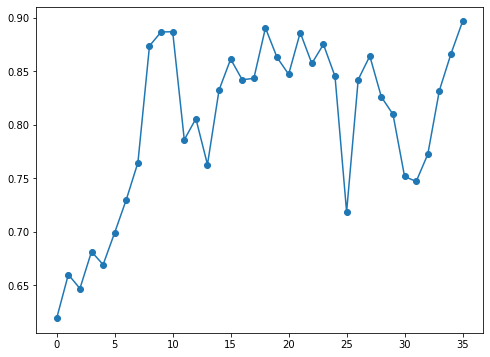

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

### Death

In [8]:
dfs_death = []
cors = []
for i in range(len(steps_d)):
    cur = steps_d[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()
    
    dfs_death.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10286.
Date:                Sun, 29 Nov 2020   Deviance:                       18515.
Time:                        21:23:06   Pearson chi2:                 5.60e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3126      0.050    -46.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death6   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9070.1
Date:                Sun, 29 Nov 2020   Deviance:                       15554.
Time:                        21:23:07   Pearson chi2:                 3.91e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6307      0.034    -18.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death11   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3932.8
Date:                Sun, 29 Nov 2020   Deviance:                       5751.3
Time:                        21:23:07   Pearson chi2:                 1.05e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.2257      0.046    -26.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death16   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5099.3
Date:                Sun, 29 Nov 2020   Deviance:                       7303.1
Time:                        21:23:08   Pearson chi2:                 1.37e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7506      0.035    -21.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death22   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4864.5
Date:                Sun, 29 Nov 2020   Deviance:                       6437.7
Time:                        21:23:08   Pearson chi2:                 9.17e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5295      0.029    -18.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death27   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4993.5
Date:                Sun, 29 Nov 2020   Deviance:                       6462.8
Time:                        21:23:09   Pearson chi2:                 9.16e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2890      0.025    -11.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death33   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7868.0
Date:                Sun, 29 Nov 2020   Deviance:                       10124.
Time:                        21:23:09   Pearson chi2:                 1.25e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5866      0.016     37.

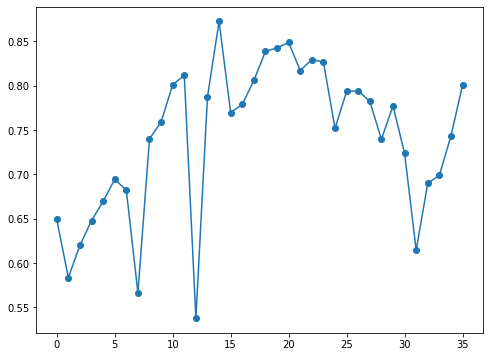

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

In [10]:
# cleanup and save
existing_csv = glob('pipeline_data/data_????-??-??_glm.csv')

if len(existing_csv) > 0:
    for csv in existing_csv:
        check_output(f'rm {csv}', shell=True)
        
df_z.to_csv(data_fname[:-4] + '_glm.csv', float_format='%.2f')

## Validation

In [11]:
cols = [col for col in df_z.columns if (col.startswith('case')) or (col.startswith('death'))]
(df_z[cols] < 0).sum().sum()

0

## Get latex tables
Let us save them to the urisk folder directly for now

In [12]:
save_folder = '/home/yihuang/Documents/TEX/pub_ds2_/urisk/Figures/data/'

In [13]:
cols = ['coef', 'z', '[0.025', '0.975]']
cols_modified = ['coef.', 'z-value', '0.025', '0.975']
df_total_case = dfs_case[-1][cols]
df_total_case.rename(columns={c: c_prime for c, c_prime in zip(cols, cols_modified)}, inplace=True)
df_total_case.rename(index={x: x.replace('_', ' ') for x in df_total_case.index}, inplace=True)
tab_case = df_total_case.to_latex(formatters={col: lambda x: f'${x:.3f}$' for col in cols_modified}, escape=False)

tab_case = tab_case.replace('perc 65yrs', '$\%65+$').replace('perc ', '$\%$')
tab_case = tab_case.replace('risk flu', 'pre-UnIT risk').replace('urban risk', 'UnIT risk')
print(tab_case)

save_fname_case = f'{save_folder}/total_case.tab'
with open(save_fname_case, 'w') as handle:
    handle.write(tab_case)

\begin{tabular}{lrrrr}
\toprule
{} &    coef. &     z-value &    0.025 &    0.975 \\
\midrule
Intercept      &  $7.311$ & $12500.000$ &  $7.310$ &  $7.312$ \\
population     &  $0.080$ &  $1377.188$ &  $0.080$ &  $0.080$ \\
$\%65+$     & $-0.119$ &  $-278.387$ & $-0.120$ & $-0.118$ \\
$\%$minority  & $-0.029$ &   $-35.118$ & $-0.030$ & $-0.027$ \\
$\%$black     & $-0.000$ &    $-0.414$ & $-0.002$ &  $0.001$ \\
$\%$hispanic  &  $0.004$ &    $12.339$ &  $0.003$ &  $0.004$ \\
$\%$poverty   & $-0.166$ &  $-243.126$ & $-0.167$ & $-0.164$ \\
income         & $-0.189$ &  $-389.803$ & $-0.190$ & $-0.188$ \\
$\%$urban pop &  $0.074$ &    $65.962$ &  $0.072$ &  $0.076$ \\
pre-UnIT risk       &  $0.112$ &   $102.536$ &  $0.110$ &  $0.114$ \\
UnIT risk     &  $1.002$ &   $720.492$ &  $0.999$ &  $1.004$ \\
\bottomrule
\end{tabular}



/usr/local/lib64/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [14]:
cols = ['coef', 'z', '[0.025', '0.975]']
cols_modified = ['coef.', 'z-value', '0.025', '0.975']
df_total_death = dfs_death[-1][cols]
df_total_death.rename(columns={c: c_prime for c, c_prime in zip(cols, cols_modified)}, inplace=True)
df_total_death.rename(index={x: x.replace('_', ' ') for x in df_total_death.index}, inplace=True)
tab_death = df_total_death.to_latex(formatters={col: lambda x: f'${x:.3f}$' for col in cols_modified}, escape=False)

tab_death = tab_death.replace('perc 65yrs', '$\%65+$').replace('perc ', '$\%$')
tab_death = tab_death.replace('risk flu', 'pre-UnIT risk').replace('urban risk', 'UnIT risk')
print(tab_death)

save_fname_death = f'{save_folder}/total_death.tab'
with open(save_fname_death, 'w') as handle:
    handle.write(tab_death)

\begin{tabular}{lrrrr}
\toprule
{} &    coef. &   z-value &    0.025 &    0.975 \\
\midrule
Intercept      &  $3.181$ & $695.230$ &  $3.172$ &  $3.190$ \\
population     &  $0.068$ & $168.326$ &  $0.067$ &  $0.068$ \\
$\%65+$     &  $0.258$ &  $98.856$ &  $0.253$ &  $0.263$ \\
$\%$minority  &  $0.131$ &  $25.166$ &  $0.121$ &  $0.141$ \\
$\%$black     &  $0.069$ &  $14.322$ &  $0.060$ &  $0.078$ \\
$\%$hispanic  &  $0.092$ &  $44.116$ &  $0.088$ &  $0.096$ \\
$\%$poverty   &  $0.158$ &  $35.637$ &  $0.149$ &  $0.167$ \\
income         &  $0.051$ &  $16.643$ &  $0.045$ &  $0.056$ \\
$\%$urban pop & $-0.046$ &  $-5.423$ & $-0.062$ & $-0.029$ \\
pre-UnIT risk       &  $0.221$ &  $27.058$ &  $0.205$ &  $0.237$ \\
UnIT risk     &  $1.125$ & $110.532$ &  $1.105$ &  $1.145$ \\
\bottomrule
\end{tabular}



In [15]:
cols = ['coef', 'z', 'P>|z|', '[0.025', '0.975]']
cols_modified = ['coef.', 'z-value', 'p-value', '0.025', '0.975']

inds = [
    'Intercept', 'population', 
    'perc_65yrs', 'perc_minority', 
    'perc_black', 'perc_hispanic', 
    'perc_poverty', 'income', 
    'perc_urban_pop', 
    'risk_flu', 'urban_risk'
]
inds_modified = [
    'Intercept', 'pop', 
    '$\%65+$', '$\%$minority', 
    '$\%$black', '$\%$hispanic', 
    '$\%$poverty', 'income', 
    '$\%$urban', 
    'pre-UnIT', 'UnIT'
]

In [17]:
for i, s in enumerate(steps):
    print(f'{i}: {s}')

0: 2020-04-04
1: 2020-04-11
2: 2020-04-18
3: 2020-04-25
4: 2020-05-02
5: 2020-05-09
6: 2020-05-16
7: 2020-05-23
8: 2020-05-30
9: 2020-06-06
10: 2020-06-13
11: 2020-06-20
12: 2020-06-27
13: 2020-07-04
14: 2020-07-11
15: 2020-07-18
16: 2020-07-25
17: 2020-08-01
18: 2020-08-08
19: 2020-08-15
20: 2020-08-22
21: 2020-08-29
22: 2020-09-05
23: 2020-09-12
24: 2020-09-19
25: 2020-09-26
26: 2020-10-03
27: 2020-10-10
28: 2020-10-17
29: 2020-10-24
30: 2020-10-31
31: 2020-11-07
32: 2020-11-14
33: 2020-11-21
34: 2020-11-28


In [18]:
start = 19
mydict = {'case': dfs_case, 'death': dfs_death}
for target, dfs in mydict.items():
    data = {}
    abnormal_p_values = []
    for i in range(start, len(steps)):

        tmp_df = dfs[i][cols].copy()
        tmp_df.drop('Intercept', axis=0, inplace=True)
        tmp_df = tmp_df.rename(columns={c: c_prime for c, c_prime in zip(cols, cols_modified)}).T
        tmp_df = tmp_df.rename(columns={c: '\texttt{{{}}}'.format(c_prime) for c, c_prime in zip(inds, inds_modified)}).T

        abnormal_p_value = tmp_df[tmp_df['p-value'] > 0.0005][['p-value']]
        if len(abnormal_p_value) > 0:
            abnormal_p_value['date'] = steps[i]
            abnormal_p_values.append(abnormal_p_value)

        for col in tmp_df.columns:
            if col != 'p-value':
                key = (steps[i][5:], col)
                data[key] = tmp_df[col]
                    
    df_abnormal_p = pd.concat(abnormal_p_values)
    print(df_abnormal_p)
    df_abnormal_p.to_csv(f'{save_folder}/abnormal_p_{target}_{start}.csv')

    df = pd.DataFrame(data=data).T
    print(df)
    
    def foo(x):
        y = abs(x)
        if y < 1:
            return f'${x:.3f}$'
        elif (y >= 1) and (y < 10):
            return f'${x:.2f}$'
        else:
            return f'${x:.1f}$'
            
    
    tab_weekly = df.to_latex(
        formatters={col: foo for col in df.columns}, 
        escape=False, 
        multirow=True)

    save_fname = f'{save_folder}/weekly_{target}_{steps[start]}.tab'
    with open(save_fname, 'w') as handle:
        handle.write(tab_weekly)

                       p-value        date
\texttt{$\%$poverty}     0.021  2020-09-05
\texttt{$\%$poverty}     0.648  2020-09-12
\texttt{$\%$minority}    0.890  2020-09-19
\texttt{$\%$urban}       0.001  2020-10-03
\texttt{pre-UnIT}        0.013  2020-11-28
               \texttt{pop}  \texttt{$\%65+$}  \texttt{$\%$minority}  \
08-15 coef.          0.0625           -0.0397                 0.3132   
      z-value      189.4000          -15.2010                75.1900   
      0.025          0.0620           -0.0450                 0.3050   
      0.975          0.0630           -0.0350                 0.3210   
08-22 coef.          0.0667           -0.1492                 0.2956   
      z-value      181.3930          -50.6040                66.2760   
      0.025          0.0660           -0.1550                 0.2870   
      0.975          0.0670           -0.1430                 0.3040   
08-29 coef.          0.0743           -0.2590                 0.1825   
      z-value      190

                       p-value        date
\texttt{$\%$minority}    0.015  2020-08-15
\texttt{$\%$urban}       0.022  2020-08-15
\texttt{$\%$minority}    0.045  2020-08-22
\texttt{$\%$black}       0.016  2020-08-22
\texttt{$\%$urban}       0.033  2020-08-22
\texttt{$\%$minority}    0.001  2020-08-29
\texttt{$\%$black}       0.231  2020-08-29
\texttt{$\%$poverty}     0.001  2020-08-29
\texttt{$\%$urban}       0.363  2020-08-29
\texttt{$\%$urban}       0.006  2020-09-05
\texttt{$\%$minority}    0.268  2020-09-12
\texttt{$\%$black}       0.004  2020-09-12
\texttt{$\%$poverty}     0.080  2020-09-12
\texttt{$\%$urban}       0.008  2020-09-12
\texttt{$\%$black}       0.186  2020-09-19
\texttt{$\%$poverty}     0.031  2020-09-19
\texttt{$\%$urban}       0.831  2020-09-19
\texttt{$\%$black}       0.174  2020-09-26
\texttt{$\%$poverty}     0.003  2020-09-26
\texttt{$\%$urban}       0.364  2020-09-26
\texttt{$\%$minority}    0.006  2020-10-03
\texttt{$\%$black}       0.024  2020-10-03
\texttt{$\%